In [1]:
import os
print(os.getcwd())

/notebooks/ControlNet


In [2]:
%pdb off

Automatic pdb calling has been turned OFF


In [3]:
from share import *

import pytorch_lightning as pl
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
from zalando_dataset import ZalandoDataset
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms
from PIL import Image

/root/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/control/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/control/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


logging improved.
Enabled sliced_attention.


In [4]:
dataset = ZalandoDataset(transform=False)
dataset = Subset(dataset, np.arange(10))
print(len(dataset))

item = dataset[2]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
mask = item['mask']
masked_image = item['masked_image']
print(jpg.shape)
print(hint.shape)
print(mask.shape)

10
(512, 512, 3)
(224, 224, 3)
(512, 512, 1)


/root/miniconda3/envs/control/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [5]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

def tensor_to_image1(tensor):
    tensor = (tensor + 1) * 127.5
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


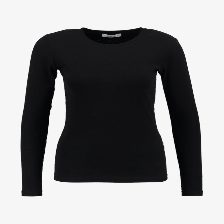

In [6]:
tensor_to_image(hint)

In [7]:
#tensor_to_image(mask)

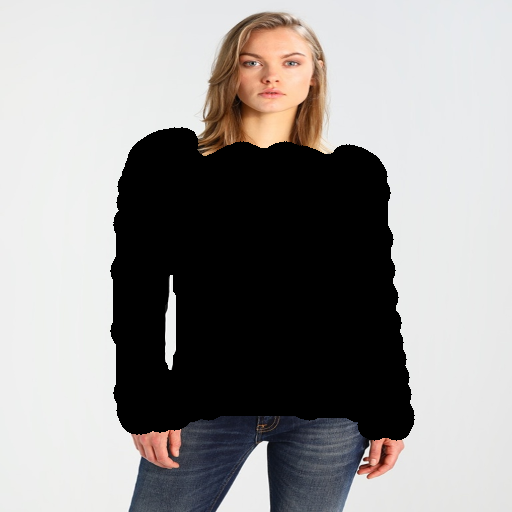

In [8]:
tensor_to_image(masked_image)

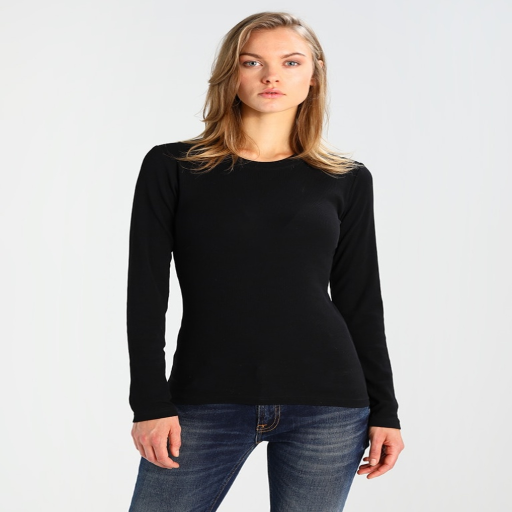

In [9]:
tensor_to_image1(jpg)

In [10]:
# np.set_printoptions(threshold=np.inf)
# masked_image

In [11]:
# Configs
root_path = '/tmp/controlnet/'
resume_path = f'/tmp/controlnet/control_sd15_ini.ckpt'
batch_size = 1
logger_freq = 1000
learning_rate = 1e-5
sd_locked = True
only_mid_control = False



# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('models/cldm_v15-mask.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control

# 3. Init ModelCheckpoint callback, monitoring "val_loss"
checkpoint_callback = ModelCheckpoint(
    dirpath=f'/storage/ckpts15/',
    every_n_train_steps = 1000,
    save_on_train_epoch_end = False,
    save_top_k = 1,
    filename="controlnet-full-{step}")

# Misc
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(gpus=1, precision=16, callbacks=[logger, checkpoint_callback], max_epochs=1500)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /root/miniconda3/envs/control/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda112.so...


/root/miniconda3/envs/control/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/root/miniconda3/envs/control/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/root/miniconda3/envs/control/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), PosixPath('443'), PosixPath('//10.43.0.1')}
  warn(msg)
/root/miniconda3/envs/control/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplot

ControlInpaintLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, c

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
# Train!
trainer.fit(model, dataloader)

/root/miniconda3/envs/control/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/root/miniconda3/envs/control/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:280: LightningDeprecationWarning: Base `LightningModule.on_train_batch_start` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
/root/miniconda3/envs/control/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:287: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                 

ControlInpaintLDM: Also optimizing conditioner params!
Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s] 

/root/miniconda3/envs/control/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


Epoch 147:  10%|█         | 1/10 [00:00<00:03,  2.25it/s, loss=0.191, v_num=147, train/loss_simple_step=0.0419, train/loss_vlb_step=0.000151, train/loss_step=0.0419, global_step=1470.0, train/loss_simple_epoch=0.141, train/loss_vlb_epoch=0.00426, train/loss_epoch=0.141]    

/root/miniconda3/envs/control/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
